## Analysis of an E-commerce Dataset Part 3 (s2 2023)


In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the ratings have been converted to like (with score 1) and dislike (with score 0). Your task is to train classification models such as KNN to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item | helpfulness | gender | category | item_id | item_price | user_city | rating |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
    
Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the like (corresponding to rating 1) and dislike (corresponding to rating 0) in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.
    

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


## Import and Explore Data 

In [2]:
#Load csv file and preview first few rows of table
df = pd.read_csv('Data/portfolio_3.csv')
df.head(100)

userId  timestamp                                             review  \
0     4081      71900                                  Not always McCrap   
1     4081      72000    I dropped the chalupa even before he told me to   
2     4081      72000                       The Wonderful World of Wendy   
3     4081     100399                               They actually did it   
4     4081     100399                               Hey! Gimme some pie!   
..     ...        ...                                                ...   
95      86      73000                                            King Me   
96    4256      42800                        A Game For The Rest Of Us..   
97    4256      42800  A nice place to live, but I wouldnt want to visit   
98    4256      50300                      I Saw it Two Days in A Row!!!   
99    4256      51200                        The Truth About The Subways   

                                         item  helpfulness gender  \
0                                  McDonald's            3      M   
1                                   Taco Bell            4      M   
2                                     Wendy's            4      M   
3          South Park: Bigger, Longer & Uncut            3      M   
4                                American Pie            3      M   
..                                        ...          ...    ...   
95                                Burger King            4      F   
96  The Sims 2: Open for Business for Windows            4      F   
97                              New York City            4      F   
98                                      Dogma            4      F   
99                              New York City            4      F   

                 category  item_id  item_price  user_city  rating  
0   Restaurants & Gourmet       41       30.74          4       1  
1   Restaurants & Gourmet       74      108.30          4       0  
2   Restaurants & Gourmet       84       69.00          4       1  
3                  Movies       68      143.11          4       1  
4                  Movies        6      117.89          4       0  
..                    ...      ...         ...        ...     ...  
95  Restaurants & Gourmet       16       49.00         15       1  
96                  Games       79       27.00         38       1  
97        Hotels & Travel       47      136.00         38       0  
98                 Movies       22       87.59         38       1  
99        Hotels & Travel       47      136.00         38       1  

[100 rows x 11 columns]

In [3]:
# Check for missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   helpfulness  2685 non-null   int64  
 5   gender       2685 non-null   object 
 6   category     2685 non-null   object 
 7   item_id      2685 non-null   int64  
 8   item_price   2685 non-null   float64
 9   user_city    2685 non-null   int64  
 10  rating       2685 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 230.9+ KB


In [4]:
#Check initial shape of the values
df.shape

(2685, 11)

### Convert object features into digit features by using an encoder

The object features to be encoded are the following: review, item, gender, category

In [5]:
#label encoding for object features - converting categorical to numerical
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df["item_code"] = ord_enc.fit_transform(df[["item"]])
df["gender_code"] = ord_enc.fit_transform(df[["gender"]])
df["category_code"] = ord_enc.fit_transform(df[["category"]])
df["review_code"] = ord_enc.fit_transform(df[["review"]])
df.head(20)

userId  timestamp                                             review  \
0     4081      71900                                  Not always McCrap   
1     4081      72000    I dropped the chalupa even before he told me to   
2     4081      72000                       The Wonderful World of Wendy   
3     4081     100399                               They actually did it   
4     4081     100399                               Hey! Gimme some pie!   
5     4081     100399                                    Good for sci-fi   
6     4081     100399                                    Scary? you bet!   
7     4081     101899                        Fox - the 4th basic channel   
8     4081     112099                                              Amen!   
9     4081     122899                                          mama mia!   
10    4081     122999                         Let's go Furby hunting, Pa   
11    4159      22304                        Good Steak for a Good Value   
12    4159      60203  Although very simple to use, it is powerful an...   
13    4159      70400            Good service but  too many busy signals   
14    4159      70500                                  decent quick food   
15    4159      70500                        good fast food with caution   
16    4159      70700                                     good fast food   
17    4159      72500                        food fast but service ain't   
18    4159      91405     Great deal for those who watch a LOT of movies   
19      50      21900             MTV has really gone downhill - part II   

                                  item  helpfulness gender  \
0                           McDonald's            3      M   
1                            Taco Bell            4      M   
2                              Wendy's            4      M   
3   South Park: Bigger, Longer & Uncut            3      M   
4                         American Pie            3      M   
5                               Matrix            3      M   
6                  Blair Witch Project            3      M   
7                                  FOX            4      M   
8                                Dogma            3      M   
9                         Olive Garden            3      M   
10                  The Original Furby            3      M   
11                  Outback Steakhouse            4      M   
12                              Google            4      M   
13                             NetZero            3      M   
14                           Taco Bell            4      M   
15                         Burger King            3      M   
16                             Wendy's            4      M   
17                          McDonald's            4      M   
18                             NetFlix            4      M   
19                                 MTV            4      F   

                    category  item_id  item_price  user_city  rating  \
0      Restaurants & Gourmet       41       30.74          4       1   
1      Restaurants & Gourmet       74      108.30          4       0   
2      Restaurants & Gourmet       84       69.00          4       1   
3                     Movies       68      143.11          4       1   
4                     Movies        6      117.89          4       0   
5                     Movies       40       24.51          4       0   
6                     Movies       12       44.00          4       1   
7                      Media       25       80.00          4       1   
8                     Movies       22       87.59          4       1   
9      Restaurants & Gourmet       49       32.00          4       1   
10             Kids & Family       78       22.38          4       0   
11     Restaurants & Gourmet       50       25.00         10       1   
12  Online Stores & Services       32      100.62         10       1   
13  Online Stores & Services       46       53.00         10       0   
14     Restaurants & Gou

In [6]:
#Identify and check the value counts/classes of the target variable

df["rating"].value_counts() 

1    1718
0     967
Name: rating, dtype: int64

<Axes: xlabel='rating', ylabel='count'>

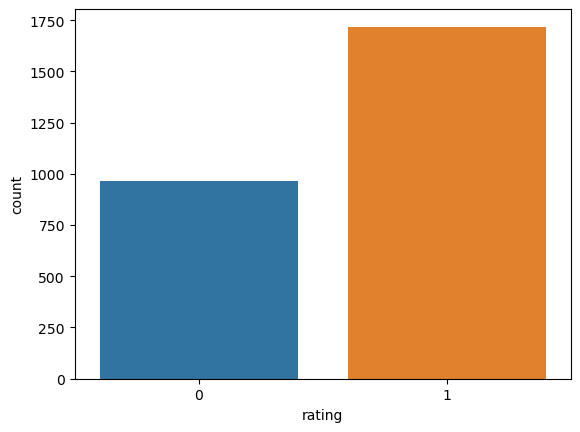

In [7]:
#Plot distribution of target variable - rating
sns.countplot(data = df, x = "rating")

### Correlation between features

In [8]:
#get correlation between features
corr_matrix = df.corr()
corr_matrix

userId  timestamp  helpfulness   item_id  item_price  \
userId         1.000000  -0.069176    -0.166136 -0.005549    0.024576   
timestamp     -0.069176   1.000000     0.014179 -0.004452    0.010979   
helpfulness   -0.166136   0.014179     1.000000 -0.019882    0.004112   
item_id       -0.005549  -0.004452    -0.019882  1.000000   -0.054450   
item_price     0.024576   0.010979     0.004112 -0.054450    1.000000   
user_city     -0.030031  -0.014934     0.012086 -0.005576   -0.023427   
rating         0.066444  -0.009739    -0.010622  0.057107    0.026062   
item_code     -0.005513  -0.003543    -0.020433  0.999765   -0.049885   
gender_code   -0.058324  -0.003367     0.075947  0.002370   -0.040596   
category_code -0.041362   0.015009    -0.013408 -0.045268   -0.115571   
review_code    0.007139   0.007029    -0.028259  0.163544   -0.041421   

               user_city    rating  item_code  gender_code  category_code  \
userId         -0.030031  0.066444  -0.005513    -0.058324      -0.041362   
timestamp      -0.014934 -0.009739  -0.003543    -0.003367       0.015009   
helpfulness     0.012086 -0.010622  -0.020433     0.075947      -0.013408   
item_id        -0.005576  0.057107   0.999765     0.002370      -0.045268   
item_price     -0.023427  0.026062  -0.049885    -0.040596      -0.115571   
user_city       1.000000 -0.034866  -0.005220    -0.065638       0.008017   
rating         -0.034866  1.000000   0.057793    -0.022169      -0.142479   
item_code      -0.005220  0.057793   1.000000     0.001925      -0.045988   
gender_code    -0.065638 -0.022169   0.001925     1.000000       0.022549   
category_code   0.008017 -0.142479  -0.045988     0.022549       1.000000   
review_code     0.045626 -0.041756   0.163090    -0.037884       0.001970   

               review_code  
userId            0.007139  
timestamp         0.007029  
helpfulness      -0.028259  
item_id           0.163544  
item_price       -0.041421  
user_city         0.045626  
rating           -0.041756  
item_code         0.163090  
gender_code      -0.037884  
category_code     0.001970  
review_code       1.000000

<Axes: >

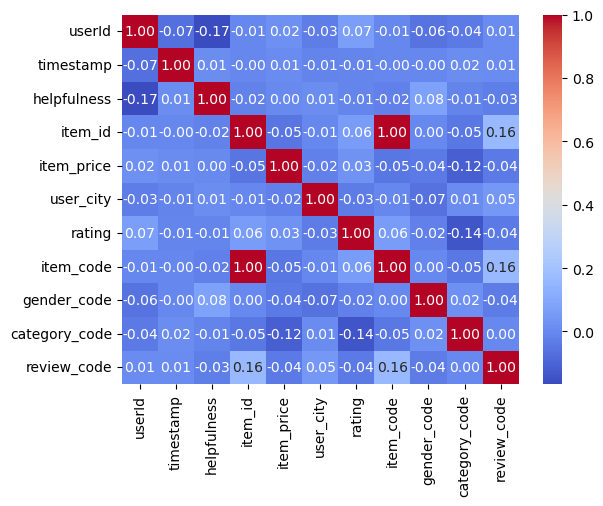

In [9]:
#Visualize correlation using heatmap
sns.heatmap(corr_matrix,annot = True, cmap = 'coolwarm', fmt='.2f' )

### Split Training and Test Data
* Training Data 80%
* Test Data 20%

<br>
Based on previous portfolio, the case with more training data yielded better and more accurate prediction results on the test data.

In [10]:
# Split data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(df, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(2148, 15)
(537, 15)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userId         2685 non-null   int64  
 1   timestamp      2685 non-null   int64  
 2   review         2685 non-null   object 
 3   item           2685 non-null   object 
 4   helpfulness    2685 non-null   int64  
 5   gender         2685 non-null   object 
 6   category       2685 non-null   object 
 7   item_id        2685 non-null   int64  
 8   item_price     2685 non-null   float64
 9   user_city      2685 non-null   int64  
 10  rating         2685 non-null   int64  
 11  item_code      2685 non-null   float64
 12  gender_code    2685 non-null   float64
 13  category_code  2685 non-null   float64
 14  review_code    2685 non-null   float64
dtypes: float64(5), int64(6), object(4)
memory usage: 314.8+ KB


In [12]:
#Define dataframes of training and testing datasets
x_train = train.drop(['userId','timestamp','rating', 'review', 'item', 'gender', 'category'], axis=1)
y_train = train['rating']
x_test = test.drop(['userId','timestamp', 'rating',  'review', 'item', 'gender', 'category'], axis=1)
y_test = test['rating']

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print(x_train.head())
print(y_train.head())

x_train shape:  (2148, 8)
y_train shape:  (2148,)
x_test shape:  (537, 8)
y_test shape:  (537,)
      helpfulness  item_id  item_price  user_city  item_code  gender_code  \
1207            4       67       71.52          2       60.0          1.0   
0               3       41       30.74          4       37.0          1.0   
1731            3       29       67.00         38       27.0          0.0   
1834            4       79       27.00         24       72.0          1.0   
1703            4       12       44.00          4       11.0          1.0   

      category_code  review_code  
1207            1.0       1946.0  
0               8.0       1618.0  
1731            5.0        860.0  
1834            1.0       2516.0  
1703            5.0        653.0  
1207    1
0       1
1731    1
1834    1
1703    0
Name: rating, dtype: int64


## Logistic Regression

Logistic regression is commonly used for prediction and classification problems. It is applied to predict a categorical dependent variable.

In [13]:
#set up logistic regression model
model = LogisticRegression()

In [14]:
model.fit(x_train, y_train)

LogisticRegression()

In [15]:
# Doing predictions on train and test set
y_hat_train = model.predict(x_train)
y_hat_test = model.predict(x_test)

### Logistic Regression - Evaluation

To evaluate a classification model we want to look at how many cases were correctly classified and how many
were in error.  In this case we have two outcomes - 0 or 1 for rating.

In [16]:
# Evaluate the performance of your trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.6396648044692738
Accuracy score on testing set:  0.6499068901303539


In [17]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on test set: 
[[ 10 168]
 [ 20 339]]


In [18]:
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))

Confusion matrix on train set: 
[[  60  729]
 [  45 1314]]


The confusion matrix on both the train test and test set is not good as it predicts more False Positives than True Positives which can be misleading to customers and also potentially ruin the creduibility of the quality of the products. This can be attributed as well to the accuracy score of the logistic regression model where the test and training data sets yielded 63-64% accuracy which is not preferred. 

### Logistic Regression - Feature Selection

The initial model used all of the features but a better model can be built by omitting some variables. By using the sklearn Recursive Feature Estimation or RFE function, it removed the features one by one and evaluates the model each time. It them selects the best model for the target number of features. In this feature selection, we are targeting 3 features to be selected. 

In [19]:
# creating RFE object
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=3)
rfe_model = rfe.fit(x_train, y_train)
print(rfe_model.support_)

[False False False False  True  True  True False]


In [20]:
#Show dataframe identify which ones are the important features
x_train.describe()

helpfulness      item_id   item_price    user_city    item_code  \
count  2148.000000  2148.000000  2148.000000  2148.000000  2148.000000   
mean      3.909683    42.879423    83.380047    19.489292    38.988827   
std       0.286702    26.779402    41.980255    11.417772    24.339756   
min       3.000000     0.000000    12.000000     0.000000     0.000000   
25%       4.000000    19.750000    49.000000     9.000000    18.750000   
50%       4.000000    42.000000    73.650000    19.000000    38.000000   
75%       4.000000    66.000000   129.820000    29.000000    59.000000   
max       4.000000    88.000000   149.000000    39.000000    81.000000   

       gender_code  category_code  review_code  
count  2148.000000    2148.000000  2148.000000  
mean      0.522346       5.018622  1341.420391  
std       0.499617       1.734772   773.616181  
min       0.000000       0.000000     0.000000  
25%       0.000000       5.000000   677.750000  
50%       1.000000       5.000000  1342.000000  
75%       1.000000       6.000000  2013.500000  
max       1.000000       8.000000  2673.000000

Based on the rfe model above, the 3 important features are <b> item_code, gender_code, and category_code. </b> We then perform logistic regression again with only these 3 features to see if the model will yield a higher accuracy this way. 

In [21]:
#Define train and test dataframes
train1, test1 = train_test_split(df, test_size=0.2, random_state=142)
print(train1.shape)
print(test1.shape)

(2148, 15)
(537, 15)


In [22]:
#Define dataframes of training and testing datasets with top 3 important features, dropping features that arent needed
x_train1 = train1.drop(['userId','timestamp','rating', 'review', 'item', 'gender', 'category', 'helpfulness', 'item_id','item_price','user_city','review_code'], axis=1)
y_train1 = train1['rating']
x_test1 = test1.drop(['userId','timestamp', 'rating',  'review', 'item', 'gender', 'category', 'helpfulness', 'item_id','item_price','user_city','review_code'], axis=1)
y_test1 = test1['rating']

print("x_train1 shape: ", x_train1.shape)
print("y_train1 shape: ", y_train1.shape)
print("x_test1 shape: ", x_test1.shape)
print("y_test1 shape: ", y_test1.shape)
print(x_train1.head())
print(y_train1.head())

rfe_model = rfe.fit(x_train1, y_train1)

x_train1 shape:  (2148, 3)
y_train1 shape:  (2148,)
x_test1 shape:  (537, 3)
y_test1 shape:  (537,)
      item_code  gender_code  category_code
1207       60.0          1.0            1.0
0          37.0          1.0            8.0
1731       27.0          0.0            5.0
1834       72.0          1.0            1.0
1703       11.0          1.0            5.0
1207    1
0       1
1731    1
1834    1
1703    0
Name: rating, dtype: int64


In [23]:
# doing evaluation
y_test_hat1 = rfe.predict(x_test1)
print("accuracy score on test set: ", accuracy_score(y_test1, y_test_hat1))

accuracy score on test set:  0.6554934823091247


In [24]:
# summarize all features
for i in range(x_train1.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000


In [25]:
# to increment number of features, one at a time
acc_scores = []
for i in range(1,4):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(x_train1, y_train1)
    # predicting on test set
    y_pred = rfe.predict(x_test1)
    acc_score = accuracy_score(y_test1, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6685288640595903
Acc on test set using 2 features:  0.6499068901303539
Acc on test set using 3 features:  0.6554934823091247


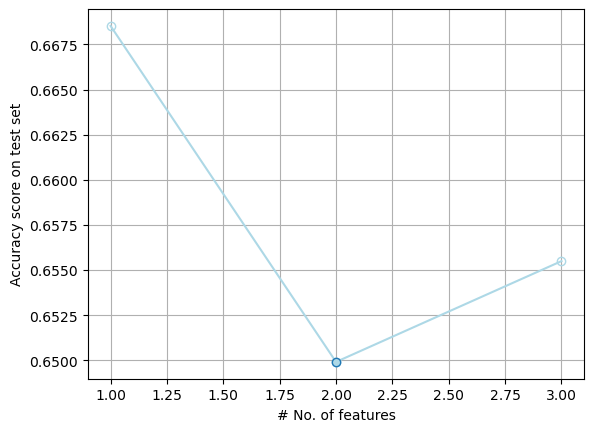

In [26]:
# Estimating accuracy score on test set using RFE by using different number of features
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 4):
    selector = RFE(estimator,n_features_to_select=i)
    selector = selector.fit(x_train1, y_train1)
    supp = selector.get_support()

    predicted = selector.predict(x_test1)
    acc_score = accuracy_score(y_test1, predicted)
    acc_scores.append(acc_score)

best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 4), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')

### Logistic Regression Analysis

From the initial Logistic Regression model, the accuracy of the test data set was about 64.9% with 8 features. From the accuracies above, the best option to go with is to include all 3 features based on the elbow method.
Despite 1 feature being the most accurate, it would be too biased if the model only had 1 dependent variable. With the 3 most significant features after feature selection, there is an increase in the accuracy from 64% with 8 features to 65% with 3 features. Recursive Feature Selection plays an integral role in minimizing the noise within the model and in choosing the optimal number of features to be included in the model. 

## K-Nearest Neighbors Model

In [27]:
# Create and train a KNN classifier model
clf = KNeighborsClassifier(n_neighbors = 10)
clf.fit(x_train, y_train)

# Use the model to predict testing data
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_pred, y_test)
print('Testing accuracy is: ', accuracy)

Testing accuracy is:  0.6052141527001862


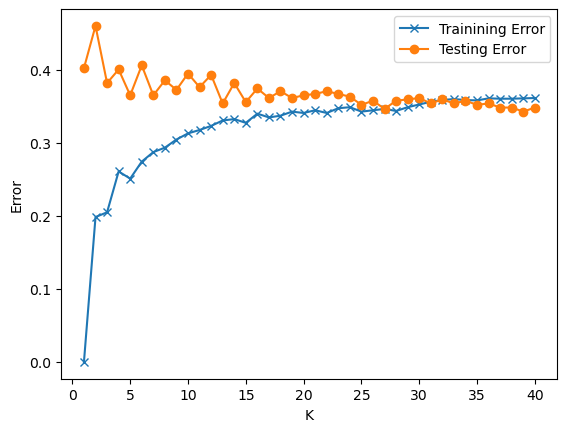

In [28]:
# Plot the accurcy trend w.r.t. K
training_error=list()
testing_error=list()

for i in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(x_train, y_train)
    training_error.append(1.0-accuracy_score(clf.predict(x_train), y_train))
    testing_error.append(1.0-accuracy_score(clf.predict(x_test), y_test))

# Plot the relationship
plt.plot(range(1, 41), training_error, marker='x', label='Trainining Error')
plt.plot(range(1, 41), testing_error, marker='o', label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

### k-fold cross validation

In [29]:
# Create a KNN classifier model and use k-fold cross validation for testing accuracy estimation
clf = KNeighborsClassifier(n_neighbors = 10)
scores = cross_val_score(clf, x_train, y_train, cv=10)
print('Accuracy for each round: \n', scores)
print('Average accuracy: %.4f +- %.4f' % (scores.mean(), scores.std()))

Accuracy for each round: 
 [0.55813953 0.63255814 0.57209302 0.57674419 0.60930233 0.62325581
 0.58139535 0.59069767 0.53271028 0.61214953]
Average accuracy: 0.5889 +- 0.0294


### Automatic model hyperparameter (algorithm parameter) tuning

In [30]:
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 41)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(x_train, y_train)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  39
The accuracy:  0.6340773744838077


### K-Nearest Neighbors Analysis

In [31]:
print('Initial KNN testing accuracy is: ', accuracy)
print('After hyperparameter tuning KNN accuracy: ', clf.best_score_)

Initial KNN testing accuracy is:  0.6052141527001862
After hyperparameter tuning KNN accuracy:  0.6340773744838077


For the K-Nearest Neighbors (KNN) section of this notebook, it was performed twice where in the the value of k in the initial KNN testing was 10 which yielded an accuracy of 60.52%. Comparing this to the KNN model with automatic model hyperparameter tuning, it evaluated that the best K value is 39 and the accuracy is 63.41%. This is aligned with the theory that the higher the k value, the higher the accuracy of the model. 

In addition, by comparing the best model using Logistic Regression and KNN, the model with the highest accuracy is the Logistic Regression model with 3 features after RFE which yielded a 65.5% accuracy which is higher than the KNN model with 39 folds. The best model for this data set would be through Logistic Regression with item, gender, and category as the independent variables in order to predict the dependent variable, rating. 